# HW08

## Exercises to practice pandas, data analysis, regression and classification

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [3]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LFWUtils
from data_utils import LinearRegression, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix, regression_error

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [5]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [6]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [7]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

,age,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference,gender_F,gender_M
count,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000
mean,29.745357,68.247321,174.558393,1763.703393,1714.265357,35.128929,62.637143,22.266786,98.850893,262.991964,84.936964,189.260179,113.919643,249.170893,570.062857,0.327321,0.672679
std,8.660975,3.869788,33.747243,110.974159,90.100600,3.215289,4.826933,3.163786,6.645711,17.408904,6.354682,11.498666,7.134157,11.856177,18.342818,0.469278,0.469278
min,17.000000,56.000000,0.000000,1323.000000,1409.000000,25.000000,46.000000,13.000000,77.000000,198.000000,67.000000,145.000000,88.000000,206.000000,502.000000,0.000000,0.000000
25%,23.000000,66.000000,150.000000,1686.000000,1651.000000,33.000000,59.000000,20.000000,94.000000,251.000000,80.000000,181.000000,109.000000,241.000000,557.000000,0.000000,0.000000
50%,28.000000,68.000000,172.000000,1770.000000,1718.000000,35.000000,62.000000,22.000000,99.000000,264.000000,86.000000,189.000000,114.000000,250.000000,570.000000,0.000000,1.000000
75%,36.000000,71.000000,195.000000,1842.000000,1779.000000,37.000000,66.000000,24.000000,104.000000,276.000000,90.000000,197.000000,118.000000,257.000000,582.000000,1.000000,1.000000
max,58.000000,94.000000,321.000000,2121.000000,1993.000000,46.000000,81.000000,34.000000,126.000000,323.000000,105.000000,239.000000,140.000000,295.000000,635.000000,1.000000,1.000000


,age,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference,gender_F,gender_M
age,1.000179,0.029467,0.217017,0.064304,0.037972,0.187740,0.292098,-0.009254,0.064993,0.048699,0.133830,0.104642,0.120726,0.038637,0.014044,-0.062201,0.062201
height,0.029467,1.000179,0.659590,0.869103,0.959988,0.355310,0.421910,0.283853,0.662081,0.820186,0.712196,0.736264,0.695159,0.554231,0.439234,-0.656634,0.656634
weight,0.217017,0.659590,1.000179,0.662828,0.682587,0.361981,0.487481,0.242281,0.708759,0.688228,0.710663,0.599894,0.591608,0.521809,0.540160,-0.562369,0.562369
span,0.064304,0.869103,0.662828,1.000179,0.899400,0.348283,0.401564,0.268229,0.681016,0.862806,0.731574,0.844382,0.796280,0.536677,0.476903,-0.648306,0.648306
stature,0.037972,0.959988,0.682587,0.899400,1.000179,0.365847,0.438604,0.289324,0.677517,0.844233,0.727613,0.761877,0.720473,0.577022,0.462999,-0.663334,0.663334
ear.breadth,0.187740,0.355310,0.361981,0.348283,0.365847,1.000179,0.454968,0.240675,0.367536,0.385165,0.415684,0.341742,0.293001,0.277395,0.221058,-0.410499,0.410499
ear.length,0.292098,0.421910,0.487481,0.401564,0.438604,0.454968,1.000179,0.382646,0.436241,0.419030,0.465829,0.335176,0.341726,0.384718,0.283878,-0.463540,0.463540
ear.protrusion,-0.009254,0.283853,0.242281,0.268229,0.289324,0.240675,0.382646,1.000179,0.294336,0.279865,0.316847,0.194417,0.204587,0.273468,0.124790,-0.413054,0.413054
foot.breadth,0.064993,0.662081,0.708759,0.681016,0.677517,0.367536,0.436241,0.294336,1.000179,0.759427,0.789143,0.661091,0.639648,0.547463,0.492590,-0.641221,0.641221
foot.length,0.048699,0.820186,0.688228,0.862806,0.844233,0.385165,0.419030,0.279865,0.759427,1.000179,0.770189,0.842393,0.797695,0.574766,0.501324,-0.669078,0.669078


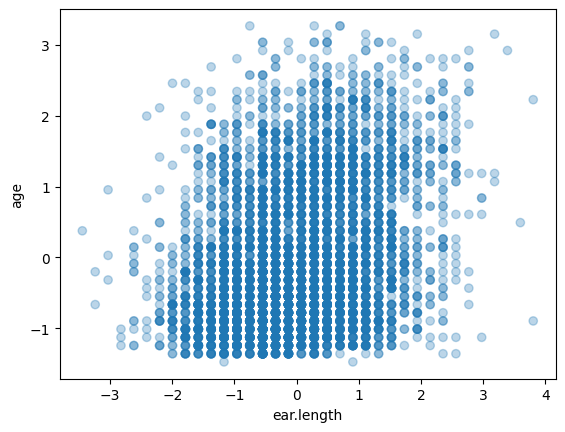

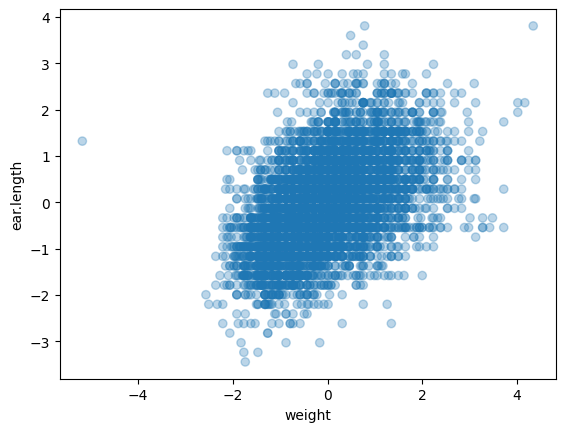

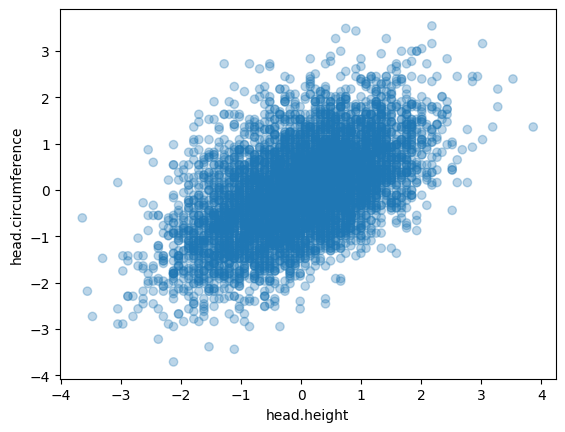

In [8]:
# Work on Data Exploration here

### Encode non-numerical features
df = pd.get_dummies(ansur_df, columns = ['gender'], dtype=int)

## 1. Print min, max, avg
display(df.describe())

### Normalize all data
ansur_scaler = StandardScaler()
df_scaled = ansur_scaler.fit_transform(df)

## 2. Print Covariances
display(df_scaled.cov())

## 3. Plot features most correlated to age, ear length and head circumference
plt.scatter(df_scaled["ear.length"], df_scaled["age"], marker='o', linestyle='', alpha=0.3)
plt.xlabel("ear.length")
plt.ylabel("age")
plt.show()

plt.scatter(df_scaled["weight"], df_scaled["ear.length"], marker='o', linestyle='', alpha=0.3)
plt.xlabel("weight")
plt.ylabel("ear.length")
plt.show()

plt.scatter(df_scaled["head.height"], df_scaled["head.circumference"], marker='o', linestyle='', alpha=0.3)
plt.xlabel("head.height")
plt.ylabel("head.circumference")
plt.show()


### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

The correlations are not always symmetric. For example, age is most correlated with weight (albeit weakly with a value of 0.22); while weight is most strongly correlated with hand.breadth with a value of 0.71. 

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

13.910571985204234


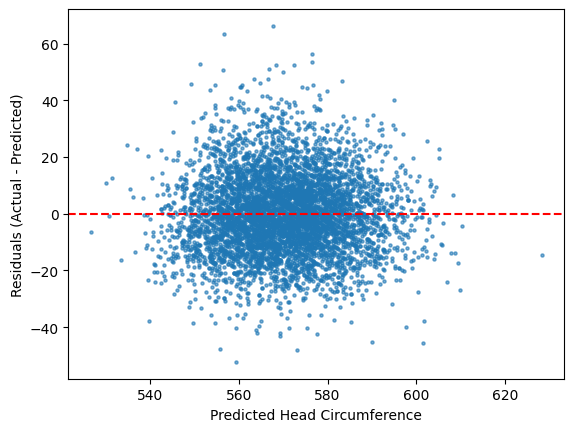

In [9]:
# Work on Regression Model here

## Separate outcome variable and input features
y = df_scaled["head.circumference"]
x = df_scaled.drop(columns = ["head.circumference"])

## Create a regression model
lr_model = LinearRegression()
lr_model.fit(x,y)
pred_x_scaled = lr_model.predict(x)
pred_x = ansur_scaler.inverse_transform(pred_x_scaled)

## Measure error on training data
print(regression_error(df["head.circumference"], pred_x))

## Plot predictions and interpret results
## Relatively good predictions with residuals are randomly distributed above and below line 0, with a few outliers
residuals = df["head.circumference"] - pred_x["head.circumference"]
plt.scatter(pred_x, residuals, s = 5, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0
plt.xlabel('Predicted Head Circumference')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

In [10]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur-test.json"
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

# g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
# ansur_test_encoded_df[["gender"]] = g_vals
ansur_test_encoded_df = pd.get_dummies(ansur_test_df, columns = ['gender'], dtype=int)

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

14.473238058423497


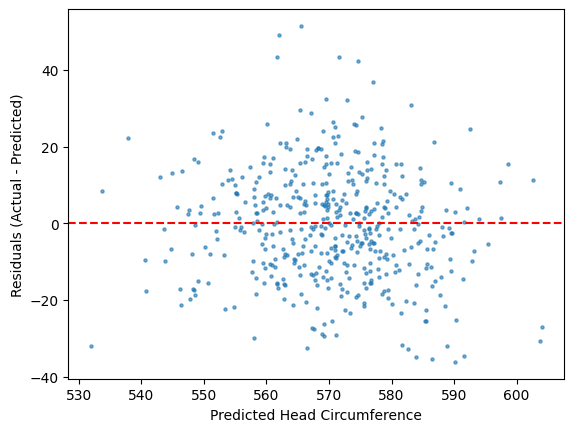

In [11]:
## Run model on test data
test_y = ansur_test_scaled_df["head.circumference"]
test_x = ansur_test_scaled_df.drop(columns = ["head.circumference"])

pred_test_x_scaled = lr_model.predict(test_x)
pred_test_x = ansur_scaler.inverse_transform(pred_test_x_scaled)

## Measure error on test data
print(regression_error(ansur_test_df["head.circumference"], pred_test_x))

## Plot predictions and interpret results
test_residuals = ansur_test_df["head.circumference"] - pred_test_x["head.circumference"]
plt.scatter(pred_test_x, test_residuals, s = 5, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at 0
plt.xlabel('Predicted Head Circumference')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()


### Interpretation

<span style="color:hotpink;">
How well does your classifier perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

Classifier performs and generalizes decently well, with regression error of 14.5 only slightly higher than 13.9. And given the average head circumference is 570, the regression error is only about 2.5%. Going by the residual plot on the test data, very small and very large head circumferences (say <550 and >580) tend to be over-predicted, i.e. the predicted value tend to be higher than thh actual value. 

This model can be improved by a few ways:
- Try taking log of the target variable to make the distribution of head circumference more uniform, which can help handle extreme values
- Try a different scaler, maybe RobustScaler instead of StandardScaler
- Try removing outliers in model training since linear regression is pretty sensitive to outliers

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/images/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [12]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/images/0801-500/train") if f.endswith(".jpg")]

In [13]:
# TODO: check and see what is inside the list here
train_files[:5]

['28-64.jpg', '31-05.jpg', '08-53.jpg', '01-30.jpg', '19-48.jpg']

Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [14]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/images/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [15]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
label_data[:5]

[23, 24, 6, 0, 15]

The labels and the filenames won't match exactly since labels start at $0$ and the filenames skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

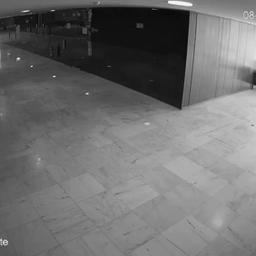

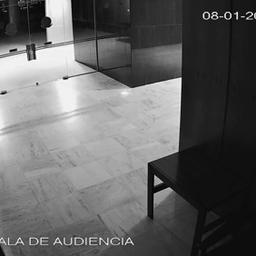

In [16]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

And now might not be a bad time to peek into the `data/images/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [17]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [18]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,99,99,99,99,99,99,99,99,99,99,...,113,115,111,106,105,106,108,107,106,23
1,89,89,89,91,95,98,100,100,101,101,...,50,60,50,49,58,61,55,54,60,24
2,138,129,66,121,134,55,58,47,67,72,...,180,179,179,179,179,179,179,179,179,6
3,17,17,17,17,17,17,17,17,22,22,...,66,64,65,67,68,69,69,68,67,0
4,49,53,43,50,53,49,59,53,47,50,...,182,176,181,187,188,185,181,179,179,15


### Test Files

If that worked, repeat the process for the test files inside the `./data/images/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [20]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/images/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
test_files[:5]

test_pixel_data = []
# TODO: loop over files and load their pixels into a list
for fname in test_files:
  img = open_image(path.join("./data/images/0801-500/test", fname))
  test_pixel_data.append(img.pixels)

# TODO: load into DataFrame (this might take 20 - 30 seconds)
test_df = pd.DataFrame(test_pixel_data)

Check the `DataFrame`

In [21]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,101,101,100,100,100,99,98,98,105,104,...,172,185,180,180,182,185,189,189,185,180
1,131,131,131,132,133,134,135,136,135,135,...,149,149,149,147,145,145,145,145,143,141
2,54,54,54,53,54,57,62,66,61,59,...,168,160,156,159,162,162,161,162,165,168
3,141,172,202,198,221,231,232,219,187,148,...,33,34,24,25,25,25,25,25,26,26
4,9,14,14,20,29,22,13,16,11,14,...,3,3,1,1,1,1,1,1,1,1


Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [22]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error
7. Run model on test data, measure error, plot predictions, interpret results

In [34]:
# TODO: create a brand new classifier
rf = RandomForestClassifier()

# TODO: fit the model
rf.fit(train_features, out_features)

# TODO: run predictions
y_pred = rf.predict(train_features)

# TODO: measure classification accuracy
regression_error(train_df.label, y_pred.label)

np.float64(0.0)

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(train_df.label, y_pred.label)

1.0

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [42]:
# TODO: run predictions on test data
y_test_pred = rf.predict(test_features)

# TODO: measure classification accuracy
# How would we measure the accuracy if we don't have labels for the test dataset?
regression_error(test_df.label, y_test_pred.label)

AttributeError: 'DataFrame' object has no attribute 'label'

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data<br>
How does the choice of pixels affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

100% prediction accuracy on training set? Am I doing something wrong? Or is this just because it's a homework example? I have not seen perfect prediction in a long time...I assume the accuracy when trying the model on the test set is less than 100%, but I'm not sure how to measure accuracy when I don't have labels for the test dataset? I'm probably missing something obvious... Usually increasing the number of features increases the accuracy, assuming the additional features are independent/not highly correlated with the existing features.